# Plot the entries per year for every year from 1990 to 2023

Total Entries for All Years: 1817177


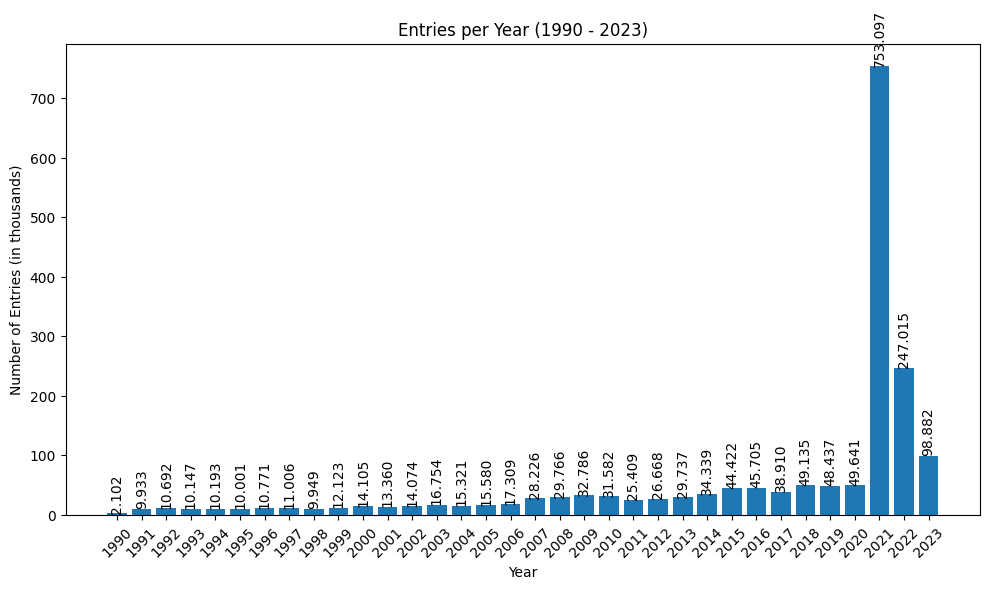

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def thousands_formatter(x, pos):
    """The two args are the value and tick position."""
    return f'{int(x / 1000)}'


def format_with_dot(num):
    """Format the number with a period as the thousands separator."""
    return f'{num:,}'.replace(',', '.')


# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2024):
    try:
        # Construct the filename
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"

        # Load the CSV file
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)

        # Count the number of entries and store it
        entries_per_year[year] = len(data)
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Plotting the data
years = list(entries_per_year.keys())
counts = list(entries_per_year.values())

# Calculate the sum of all years' entries
total_entries = sum(counts)
print(f"Total Entries for All Years: {total_entries}")

plt.figure(figsize=(10, 6))
bars = plt.bar(years, counts)
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('Entries per Year (1990 - 2023)')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    formatted_value = format_with_dot(yval)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, formatted_value,
             va='bottom', ha='center', rotation=90)

plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()


# Plot the entries per year for every year before Covid-19 (first vaccinations started Dezember 2020)

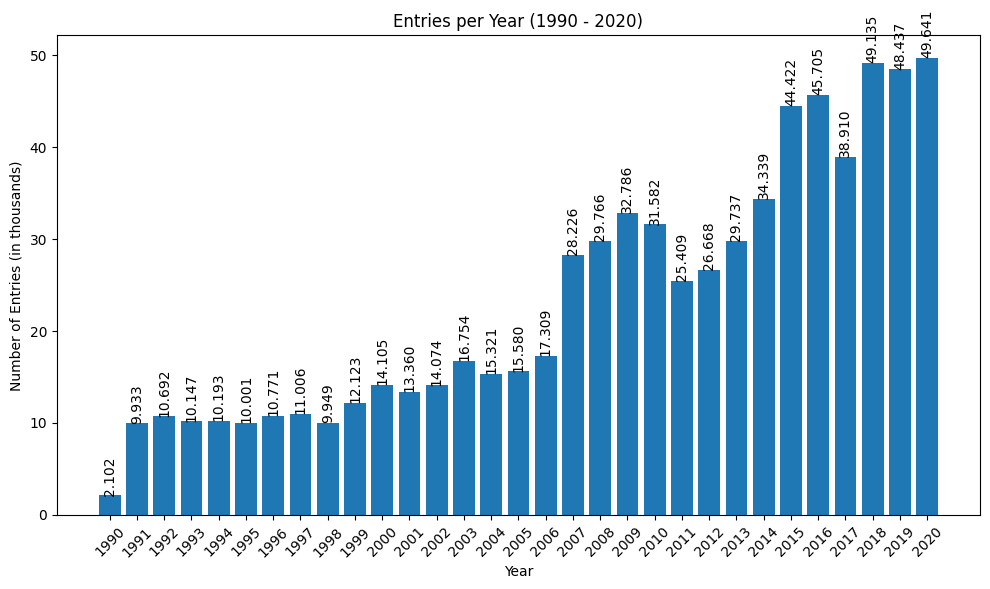

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def thousands_formatter(x, pos):
    """The two args are the value and tick position."""
    return f'{int(x / 1000)}'


def format_with_dot(num):
    """Format the number with a period as the thousands separator."""
    return f'{num:,}'.replace(',', '.')


# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2021):
    try:
        # Construct the filename
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"

        # Load the CSV file
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)

        # Count the number of entries and store it
        entries_per_year[year] = len(data)
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Plotting the data
years = list(entries_per_year.keys())
counts = list(entries_per_year.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(years, counts)
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('Entries per Year (1990 - 2020)')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each bar with its value
for bar in bars:
    yval = bar.get_height()
    formatted_value = format_with_dot(yval)
    plt.text(bar.get_x() + bar.get_width() / 2, yval, formatted_value,
             va='bottom', ha='center', rotation=90)

plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

# Plot percentage change in relation to prior year

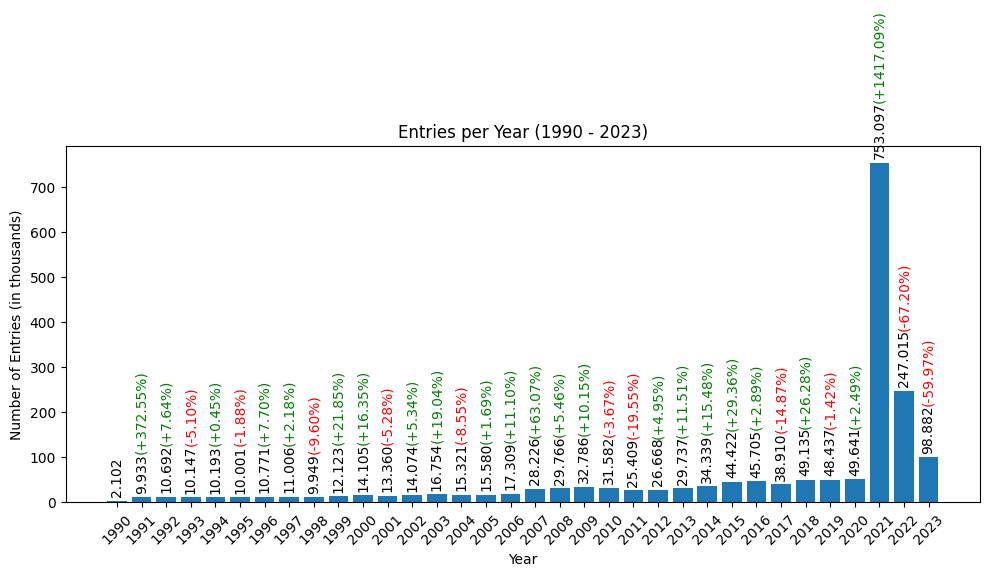

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2024):
    try:
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)
        entries_per_year[year] = len(data)
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert to DataFrame and calculate percentage change
df = pd.DataFrame(list(entries_per_year.items()), columns=['Year', 'Count'])
df['Pct_Change'] = df['Count'].pct_change() * 100

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Year'], df['Count'])

plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('Entries per Year (1990 - 2023)')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

count = 0 
# Annotate each bar with its value and percentage change
for bar, pct_change in zip(bars, df['Pct_Change']):
    
    yval = bar.get_height()
    formatted_value = format_with_dot(yval)

    # Annotate with the count value in default color
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10000, formatted_value,
             va='bottom', ha='center', rotation=90)
    # Determine the color based on the percentage change
    if count != 0:
        color = 'green' if pct_change > 0 else 'red' if pct_change < 0 else 'black'
        if yval < 10000:
            offset = 97500
        elif yval >= 10000 and yval < 100000:
            offset = 115000
        else: offset = 135000
        # Annotate with the percentage change in colored text
        plt.text(bar.get_x() + bar.get_width()/2, yval + offset , f"({pct_change:+.2f}%)",
                 va='bottom', ha='center', rotation=90, color=color)
    count+=1

plt.xticks(df['Year'], rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/Entries_per_Year.png')
plt.show()

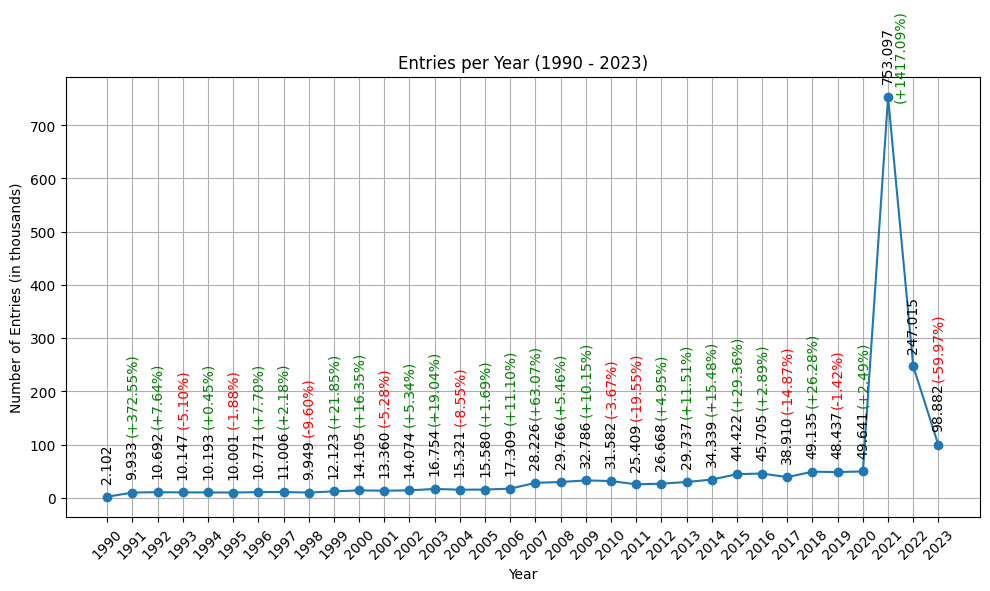

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Loop through each year from 1990 to 2023
for year in range(1990, 2024):
    try:
        path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        filename = f"{year}VAERSDATA.csv"
        data = pd.read_csv(path + filename, encoding="Iso-8859-1", low_memory=False)
        entries_per_year[year] = len(data)
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert to DataFrame and calculate percentage change
df = pd.DataFrame(list(entries_per_year.items()), columns=['Year', 'Count'])
df['Pct_Change'] = df['Count'].pct_change() * 100

# Plotting the data as a line graph
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Count'], marker='o', linestyle='-', label='Number of Entries')
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('Entries per Year (1990 - 2023)')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

count = 0
# Annotate each point with its value and percentage change
for year, count, pct_change in zip(df['Year'], df['Count'], df['Pct_Change']):
    formatted_value = format_with_dot(count)

    # Annotate with the count value in default color, larger font size, and rotated 90 degrees
    plt.annotate(formatted_value, (year, count + 5000), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90)

    # Determine the color based on the percentage change
    if count != df['Count'].iloc[0]:
        color = 'green' if pct_change > 0 else 'red' if pct_change < 0 else 'black'
        if count < 10000:
            offset = 85500
            xoffset= 0 
        elif count >= 10000 and count < 100000:
            offset = 100000
            xoffset= 0
        elif count >= 100000 and count < 250000:
            offset = 1150000
            xoffset= 0
        else:
            offset = -30000  # Adjust the offset to the right
            xoffset= 0.5
        # Annotate with the percentage change in colored text, larger font size, and rotated 90 degrees
        plt.annotate(f"({pct_change:+.2f}%)", (year + xoffset, count + offset), textcoords="offset points", xytext=(0, 10),
                     ha='center', fontsize=10, rotation=90, color=color)  # Adjust the x-position (year + 0.25)

plt.xticks(df['Year'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/Entries_per_Year_dotted.png')
plt.show()



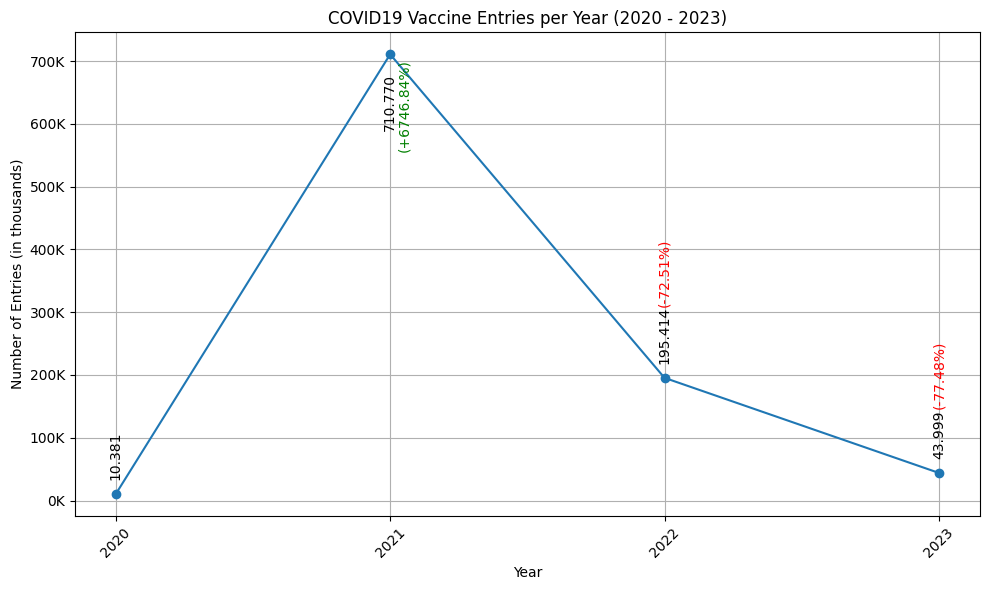

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}K'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# Initialize a dictionary to store the number of COVID19 vaccine entries per year
covid_entries_per_year = {}

# Loop through each year from 2020 to 2023
for year in range(2020, 2024):  # Adjust the years if necessary
    try:
        data_path = "/Users/sep/Documents/HAW/Masterarbeit/Daten.nosync/"
        data_filename = f"{year}VAERSDATA.csv"
        vax_filename = f"{year}VAERSVAX.csv"

        # Load the datasets
        data_df = pd.read_csv(data_path + data_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID'])
        vax_df = pd.read_csv(data_path + vax_filename, encoding="Iso-8859-1", low_memory=False, usecols=['VAERS_ID', 'VAX_TYPE'])

        # Filter VAERSVAX for COVID19 and merge
        covid_vax_df = vax_df[vax_df['VAX_TYPE'] == 'COVID19']
        merged_df = pd.merge(data_df, covid_vax_df, on='VAERS_ID')
        merged_df = merged_df.drop_duplicates(subset=['VAERS_ID'])

        covid_entries_per_year[year] = len(merged_df)
    except FileNotFoundError:
        print(f"File for year {year} not found.")
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Convert to DataFrame and calculate percentage change
df = pd.DataFrame(list(covid_entries_per_year.items()), columns=['Year', 'Count'])
df['Pct_Change'] = df['Count'].pct_change() * 100

# Plotting the data as a line graph
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Count'], marker='o', linestyle='-', label='Number of COVID19 Entries')
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('COVID19 Vaccine Entries per Year (2020 - 2023)')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value and percentage change
for year, count, pct_change in zip(df['Year'], df['Count'], df['Pct_Change']):
    formatted_value = format_with_dot(count)
    
    offset = 5000
    # Annotate with the count value
    if year == 2021: 
        offset = -140000
    
    

    plt.annotate(formatted_value, (year, count + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90)

    # Determine the color based on the percentage change
    if count != df['Count'].iloc[0]:
        color = 'green' if pct_change > 0 else 'red' if pct_change < 0 else 'black'
        if count < 100000:
            offset = 85000
            xoffset= 0 
        elif count >= 100000 and count < 200000:
            offset = 95000
            xoffset= 0
        else:
            offset = -172500
            xoffset= 0.05
        # Annotate with the percentage change in colored text, larger font size, and rotated 90 degrees
        plt.annotate(f"({pct_change:+.2f}%)", (year + xoffset, count + offset), textcoords="offset points", xytext=(0, 10),
                     ha='center', fontsize=10, rotation=90, color=color)  # Adjust the x-position (year + 0.25)

plt.xticks(df['Year'], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/COVID19_Entries_per_Year_dotted.png')
plt.show()
